### Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. This notebook takes developes a meanshift clustering algorithm and applies it firstly on a CPU and then on a GPU.

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

### Create Data

In [3]:
n_clusters=7
n_samples =220

First generate cluster centroids over range -35 to +35

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551],
        [ 25.858,   4.740]])

In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [6]:
def sample(m, n_samples): 
    # Create an identity matrix as covarance matrix, to effectivly isolate each population
    return MultivariateNormal(m, torch.diag(tensor([7.,7.]))).sample((n_samples,))

In [7]:
sample_slices = [sample(c, n_samples) for c in centroids]
data = torch.cat(sample_slices)
data.shape, data[0:5]

(torch.Size([1540, 2]),
 tensor([[25.495, 30.426],
         [31.104, 28.628],
         [25.443, 30.213],
         [24.753, 31.903],
         [30.921, 26.609]]))

In [8]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        # plot the samples for the centroid
        ax.scatter(samples[:,0], samples[:,1], s=1)
        # plot the centroid in large symbol
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        # add a smaller version with a different color
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

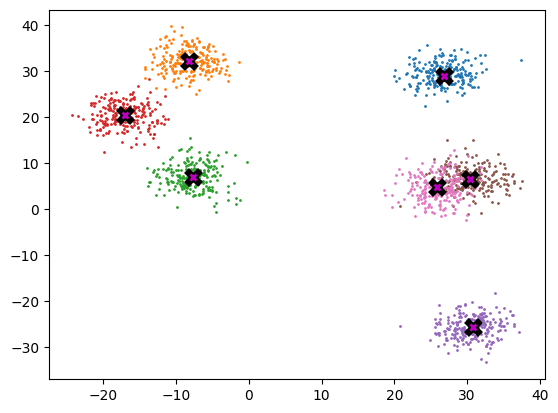

In [9]:
plot_data(centroids, data, n_samples)

### Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [11]:
# Generate a gaussian function
def gaussian(d, bw): 
    """
    args:
        d: vector of difference x-mu
        bw: bandwidth - in this case the sd
    """
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

Now plot the gaussian

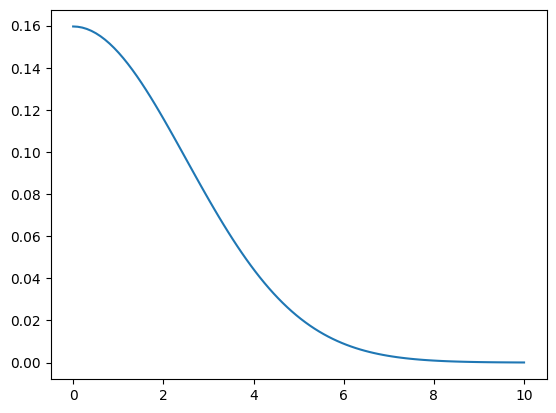

In [12]:
x_vals = torch.linspace(0, 10, 100)
f = partial(gaussian, bw=2.5)
plt.plot(x_vals, f(x_vals))

Note that the kernal can be anything and not necessarily gaussian, for example a simple linear decay to zero would also likely work.

As a rule a bandwidth of about a third of the range of the data is reasonable

To work out meanshift the distance from each point to every other point has to be calculated

In [15]:
X = data.clone()
x=X[0]
x.shape, X.shape

(torch.Size([2]), torch.Size([1540, 2]))

To find the dx, dy distance from one point to any other we can subtract the vector using broadcasting (the first dims match and the second is not present but will be expanded by broadcasting

In [16]:
X[:8]

tensor([[25.495, 30.426],
        [31.104, 28.628],
        [25.443, 30.213],
        [24.753, 31.903],
        [30.921, 26.609],
        [30.143, 32.480],
        [28.374, 32.582],
        [26.146, 29.161]])

In [17]:
X-x

tensor([[  0.000,   0.000],
        [  5.609,  -1.798],
        [ -0.052,  -0.213],
        ...,
        [  1.507, -30.177],
        [ -1.959, -27.449],
        [  1.278, -26.208]])

In [18]:
(x-X).shape

torch.Size([1540, 2])

In [19]:
# Calculate the euclidian distance between the first point and every other
dist = ((x-X)**2).sum(1).sqrt()

In [20]:
# Create a weight for every point based upon the kernal function
weight = gaussian(dist, 2.5)
weight[0:8]

tensor([0.160, 0.010, 0.159, 0.128, 0.005, 0.020, 0.057, 0.136])

In [23]:
weight[:, None]*X

tensor([[    4.068,     4.855],
        [    0.309,     0.285],
        [    4.044,     4.803],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [26]:
def one_update_jh(X):
    """ Note that this changes X as the array is processed.  It reaches the same end
    result, but the whole of X should be changed in one go rather than incrementally
    """
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = gaussian(dist, 2.5)
#        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()
    return X

In [23]:
X_jh = data.clone()
X_jh = one_update_jh(X_jh)
X_jh[0:10]

tensor([[26.112, 29.895],
        [28.963, 28.996],
        [26.093, 29.787],
        [25.727, 30.577],
        [28.865, 28.185],
        [28.490, 30.874],
        [27.611, 30.891],
        [26.506, 29.300],
        [23.247, 28.814],
        [24.632, 28.101]])

In [24]:
def meanshift_jh(data):
    X = data.clone()
    for it in range(5): one_update_jh(X)
    return X

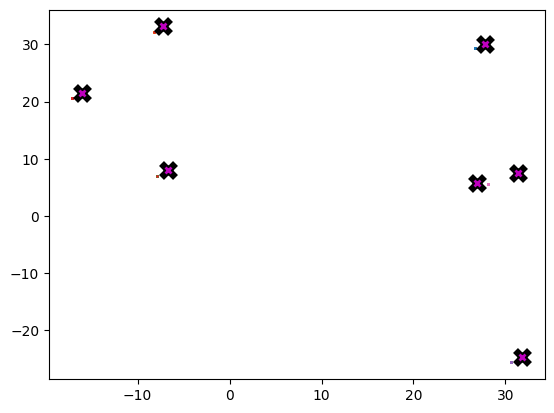

In [25]:
X=meanshift_jh(data.clone())
plot_data(centroids+1, X, n_samples)

### Animation the changes with each iteration

In [27]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.core.debugger import Pdb

In [28]:
gauss2_5 = partial(gaussian, bw=2.5)

In [29]:
class MeanShift_1():
    
    def __init__(self, data, centroids, weight_function, n_samples, learn_rate=1.0, interval=500, repeat=False):
        
        self.X = data.clone()
        self.centroids = centroids
        self.weight_function = weight_function
        self.learn_rate = learn_rate
        self.interval = interval
        self.repeat = repeat
        self.n_samples = n_samples
        
    def one_update(self):
        Y = torch.zeros_like(self.X)
        for i, x in enumerate(self.X):
            dist = torch.sqrt(((x-self.X)**2).sum(1))
            weight = self.weight_function(dist)
    #        weight = tri(dist, 8)
            Y[i] = (weight[:,None]*self.X).sum(0)/weight.sum()
        return Y       
    
    def do_one_pass(self, d):
        if d > 0 : 
            self.X = self.one_update()
        ax.clear()
        plot_data(self.centroids+2, self.X, self.n_samples, ax=ax)
        
    def animate(self):
        pass

In [36]:
ms = MeanShift_1(data, centroids, weight_function=gauss2_5, n_samples=n_samples)

In [37]:
fig,ax = plt.subplots()
ani = FuncAnimation(fig, ms.do_one_pass, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

In [38]:
from sklearn.cluster import MeanShift
import numpy as np

In [39]:
ms_skl = MeanShift(bandwidth=3.5, bin_seeding=True).fit(data.clone())

In [40]:
labels = ms_skl.labels_
cluster_centers = ms_skl.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 8


In [45]:
my_members = labels == 2
X[my_members, 0]

tensor([-7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865,
        -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865,
        -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865,
        -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865,
        -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865,
        -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865,
        -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865, -7.865,
        -7.865, -7.865, -7.865, -7.865, -7.865, 

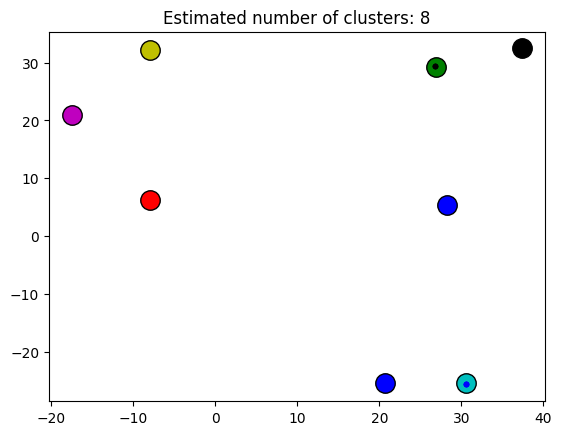

In [41]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

### GPU approach

Firstly process a batch of points

In [137]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1540, 2]))

In [152]:
x

tensor([[25.495, 30.426],
        [31.104, 28.628],
        [25.443, 30.213],
        [24.753, 31.903],
        [30.921, 26.609]])

In [142]:
X[0:5]

tensor([[25.495, 30.426],
        [31.104, 28.628],
        [25.443, 30.213],
        [24.753, 31.903],
        [30.921, 26.609]])

In [167]:
x[:,None].shape, X[None].shape

(torch.Size([5, 1, 2]), torch.Size([1, 1540, 2]))

In [166]:
squares= ( X[None] - x[:, None]).sum(2)
squares.shape

torch.Size([5, 1540])

In [169]:
squares[:, 0:7]

tensor([[ 0.000,  3.811, -0.265,  0.735,  1.608,  6.702,  5.034],
        [-3.811,  0.000, -4.076, -3.076, -2.203,  2.891,  1.224],
        [ 0.265,  4.076,  0.000,  1.000,  1.873,  6.967,  5.299],
        [-0.735,  3.076, -1.000,  0.000,  0.873,  5.967,  4.299],
        [-1.608,  2.203, -1.873, -0.873,  0.000,  5.094,  3.426]])

In [153]:
# Create a function to process a batch of points and generate th distances wetween them
# Note that the expansion produces an assitional middle column in X when broadcase, which then allows
def distance_batch(a, b):
    squares = ((a[None]-b[:, None, :])**2).sum(2)
    # squares has shape b.shape[0], a.shape[0]
    res = squares.sqrt()
    return res
    

In [170]:
dist = distance_batch(X, x)

In [171]:
dist.shape

torch.Size([5, 1540])

In [172]:
weight =gaussian(distance_batch(X, x), 2.5)
weight.shape

torch.Size([5, 1540])

In [173]:
weight, weight.shape, X.shape

(tensor([[    0.160,     0.010,     0.159,  ...,     0.000,     0.000,     0.000],
         [    0.010,     0.160,     0.010,  ...,     0.000,     0.000,     0.000],
         [    0.159,     0.010,     0.160,  ...,     0.000,     0.000,     0.000],
         [    0.128,     0.003,     0.122,  ...,     0.000,     0.000,     0.000],
         [    0.005,     0.115,     0.005,  ...,     0.000,     0.000,     0.000]]),
 torch.Size([5, 1540]),
 torch.Size([1540, 2]))

We now need to multiply the first axis of the weights * distance for each point of the batch

In [174]:
weight[..., None].shape, X[None].shape

(torch.Size([5, 1540, 1]), torch.Size([1, 1540, 2]))

In [178]:
# Get the sum of the weights * X
wt_X_sum = (weight[..., None] * X[None]).sum(1)

In [184]:
wt_X_sum.shape, wt_X_sum

(torch.Size([5, 2]),
 tensor([[406.997, 465.962],
         [246.740, 247.000],
         [411.003, 469.521],
         [293.403, 349.040],
         [191.774, 186.939]]))

In [194]:
# get the sum of the weights
wt_sum = weight.sum(1, keepdim=True)
wt_sum.shape, wt_sum

(torch.Size([5, 1]),
 tensor([[15.587],
         [ 8.518],
         [15.759],
         [11.412],
         [ 6.634]]))

In [195]:
new_X = wt_X_sum / wt_sum

In [196]:
new_X.shape, new_X

(torch.Size([5, 2]),
 tensor([[26.112, 29.895],
         [28.965, 28.996],
         [26.081, 29.794],
         [25.711, 30.586],
         [28.908, 28.180]]))

#### Achive the same thing using Einsum
In this case we don't need to add the additional dimensions manually that we did above

In [188]:
wt_X_sum = torch.einsum("ij, jk -> ik", weight, X)

In [192]:
wt_X_sum.shape, wt_X_sum

(torch.Size([5, 2]),
 tensor([[406.997, 465.962],
         [246.740, 247.000],
         [411.003, 469.521],
         [293.403, 349.040],
         [191.774, 186.939]]))

In [197]:
new_X = wt_X_sum / wt_sum

In [199]:
new_X

tensor([[26.112, 29.895],
        [28.965, 28.996],
        [26.081, 29.794],
        [25.711, 30.586],
        [28.908, 28.180]])

#### And also with the torch @ operator

In [200]:
wt_X_sum = weight@X
wt_X_sum.shape, wt_X_sum

(torch.Size([5, 2]),
 tensor([[406.997, 465.962],
         [246.740, 247.000],
         [411.003, 469.521],
         [293.403, 349.040],
         [191.774, 186.939]]))

In [201]:
new_X = wt_X_sum / wt_sum

In [202]:
new_X

tensor([[26.112, 29.894],
        [28.965, 28.996],
        [26.081, 29.794],
        [25.711, 30.586],
        [28.908, 28.180]])

### Create a Cuda capable function for MeanShift

In [208]:
def meanshift(data, weight_function, bs=512, iterations=5):
    X = data.clone()
    n_samples = data.shape[0]
    X_new = torch.zeros_like(X)
    for it in range(iterations):
        for start in range(0, n_samples, bs):
            # Load a batch of data
            s = slice(start, min(start+bs, n_samples))
            dist = distance_batch(X, X[s])
            weights = weight_function(dist)
            wt_X_sum = weights@X
            wt_sum = weights.sum(axis=1, keepdim=True)
            X_new[s] = wt_X_sum/wt_sum
        X = X_new
            
    return X

In [213]:
%timeit res = meanshift(data, gauss2_5)

414 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [210]:
res

tensor([[26.727, 29.438],
        [26.727, 29.438],
        [26.727, 29.438],
        ...,
        [28.151,  5.627],
        [28.151,  5.627],
        [28.151,  5.627]])

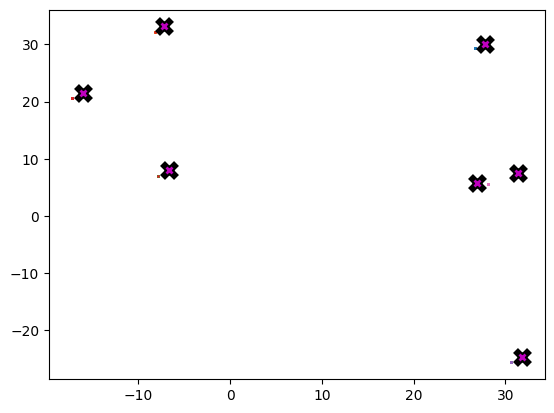

In [212]:
plot_data(centroids+1, res, n_samples)